In [161]:
from cluster import KMeans, make_clusters
import numpy as np
from scipy.spatial.distance import cdist
from collections import defaultdict
from matplotlib import pyplot as plt

In [191]:
class KMeans_home:
    def __init__(self, k: int, tol: float = 1e-6, max_iter: int = 100):
        """
        In this method you should initialize whatever attributes will be required for the class.

        You can also do some basic error handling.

        What should happen if the user provides the wrong input or wrong type of input for the
        argument k?

        inputs:
            k: int
                the number of centroids to use in cluster fitting
            tol: float
                the minimum error tolerance from previous error during optimization to quit the model fit
            max_iter: int
                the maximum number of iterations before quitting model fit
        """

        """
        Check input parameters are of correct type
        """

        # Check that k is an integer
        try:
            val = int(k)
        except ValueError:
            print("Input k value is not an integer. Re-enter a k with integer value.")

        # Check that minimum error tolerance is a float value
        try:
            val = float(tol)
        except ValueError:
            print("Input minimum error tolerance value is not a float. "
                  "Re-enter a minimum error tolerance with float value.")

        # Check that max_iter value is an integer
        try:
            val = int(max_iter)
        except ValueError:
            print("Input maximum iteration value is not an integer. "
                  "Re-enter a maximum iteration input with integer value.")

        """
        Initialize attributes
        """
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

        self.centroids = None
        self.mean_squared_error = None

    def fit(self, mat: np.ndarray):
        """
        Fits the kmeans algorithm onto a provided 2D matrix.
        As a bit of background, this method should not return anything.
        The intent here is to have this method find the k cluster centers from the data
        with the tolerance, then you will use .predict() to identify the
        clusters that best match some data that is provided.

        In sklearn there is also a fit_predict() method that combines these
        functions, but for now we will have you implement them both separately.

        inputs:
            mat: np.ndarray
                A 2D matrix where the rows are observations and columns are features
        """
        # Create an initial centroid
        self._generate_init_centroid(mat)

        # Generate k centroids
        self._generate_k_centroids(mat)

        # Calculate the sum of squares error for this first set of k centroids
        prev_error = self._generate_error_per_centroid(mat)

        # No other error here so set error_diff to prev_error
        curr_error = prev_error

        error_diff_dict = {}

        for key in curr_error:
            error_diff_dict[key] = np.absolute((prev_error[key])[0] - (curr_error[key])[0])

        # max_iter - 1 because already went through one iteration
        for i in range(self.max_iter-1):
            for values in error_diff_dict.values():
                if float(values) > self.tol:
                    self._update_centroids(mat)
                else:
                    self.mean_squared_error = float(sum(error_diff_dict.values())) / float(len(error_diff_dict.values()))
                    break

    def predict(self, mat: np.ndarray) -> np.ndarray:
        """
        Predicts the cluster labels for a provided matrix of data points--
            question: what sorts of data inputs here would prevent the code from running?
            How would you catch these sorts of end-user related errors?
            What if, for example, the matrix is of a different number of features than
            the data that the clusters were fit on?

        inputs:
            mat: np.ndarray
                A 2D matrix where the rows are observations and columns are features

        outputs:
            np.ndarray
                a 1D array with the cluster label for each of the observations in `mat`
        """
        try:
            mat.ndim == 2
        except TypeError:
            print('Incorrect number of dimensions:' + mat.ndim)

        # Running self._assign_cluster(mat) would return a dictionary with keys as labels, values as data points
        #new_assign = self._assign_cluster(mat)

        """
        Code below plots points colored by their label:
        for key, data_list in new_assign.items():
            key, values = zip(*data_list)  # Unpack
            plt.scatter(key, values, label=key)
        plt.show()
        """

        cluster_labels = self._return_matrix_of_labels(mat)

        return cluster_labels

    def get_error(self) -> float:
        """
        Returns the final squared-mean error of the fit model. You can either do this by storing the
        original dataset or recording it following the end of model fitting.

        outputs:
            float
                the squared-mean error of the fit model
        """
        return self.mean_squared_error

    def get_centroids(self) -> np.ndarray:
        """
        Returns the centroid locations of the fit model.

        outputs:
            np.ndarray
                a `k x m` 2D matrix representing the cluster centroids of the fit model
        """
        return self.centroids

    def _generate_init_centroid(self, mat: np.ndarray):
        self.centroids = []
        initial_index = np.random.choice(range(mat.shape[0]), )
        self.centroids.append(mat[initial_index, :].tolist())

    def distance_from_centroids(self, mat: np.ndarray):
        centroids = self.centroids
        dist = cdist(mat, np.array(self.centroids))

        # Already calculating (minimum) distance between points in mat and closest centroid
        dist_squared = np.array([min([np.linalg.norm(m-c)**2 for c in centroids]) for m in mat])
        self.dist_squared = dist_squared
        return self.dist_squared

    def _distance_from_centroids(self, mat: np.ndarray):
        centroids = self.centroids
        dist = cdist(mat, np.array(self.centroids))

        # Already calculating (minimum) distance between points in mat and closest centroid
        dist_squared = np.array([min([np.linalg.norm(m-c)**2 for c in centroids]) for m in mat])
        self.dist_squared = dist_squared

    def _choose_next_centroid(self, mat: np.ndarray):
        self.probs = self.dist_squared / self.dist_squared.sum()
        self.cumulative_probs = self.probs.cumsum()
        r = np.random.uniform(low=0.0, high=1.0)
        index = np.where(self.cumulative_probs >= r)[0][0]
        return mat[index]

    def _generate_k_centroids(self, mat: np.ndarray):
        self._generate_init_centroid(mat)
        while len(self.centroids) < self.k:
            self._distance_from_centroids(mat)
            self.centroids.append(self._choose_next_centroid(mat))
        self.centroids = np.array(self.centroids)

    def _determine_error(self, mat: np.ndarray) -> np.ndarray:
        centroids = self.get_centroids()
        sum_of_squares_error = np.array([np.square([np.sum((m-c)**2) for c in centroids]) for m in mat])
        return sum_of_squares_error

    def _assign_cluster(self, mat: np.ndarray) -> defaultdict:

        # I created a dictionary assigning each point to the centroid for which error is minimum
        assignment_dict = defaultdict(list)

        error = self._determine_error(mat)

        for index, val in enumerate(error):
            min_dist_index = np.argmin(error[index])
            assignment_dict[min_dist_index].append(mat[index])

        return assignment_dict

    def _update_centroids(self, mat: np.ndarray):
        # Creates a dictionary in which keys are centroids and values are the data points assigned to them
        class_dict = self._assign_cluster(mat)

        # Initialize a dictionary with mean coordinates for each cluster center
        mean_dict = defaultdict(list)

        # Iterate through the k keys
        for i in class_dict.keys():
            # Pass the values of class_dict into a list and assign to dict_values
            dict_values = list(class_dict.values())

            # Select the values corresponding to the ith key
            dict_values_curr = dict_values[i]

            # Take the mean of all the n observations and m features across each data point in a particular cluster
            dict_val_mean = map(np.mean, zip(*dict_values_curr))

            # Make dict_val_mean a list
            dict_val_mean = list(dict_val_mean)

            # Append mean_dict with the mean associated with the m and n values
            mean_dict[i].append(dict_val_mean)

        # Reset self.centroids to be empty
        self.centroids = []

        # Loop through the number of centroids until you have added k centroids
        while len(self.centroids) < self.k:

            # Iterate through mean_dict
            for key, value in mean_dict.items():
                # Assign the k key values to be indices for the self.centroids array
                index = key
                # Insert the associated mean values to a specific index
                self.centroids.insert(index, value)

        # Reshape self.centroids array to be m x n dimensions
        self.centroids = np.squeeze(np.array(self.centroids), axis=(1,))

    def _generate_error_per_centroid(self, mat: np.ndarray):
        # Returns dictionary of summed errors per cluster
        error_dict = defaultdict(list)
        error = self._determine_error(mat)
        for index, val in enumerate(error):
            min_dist_index = np.argmin(error[index])
            error_dict[min_dist_index].append(val[min_dist_index])

        # Calculate error of all assigned points in a particular cluster
        sum_errors_dict = {k: [sum(error_dict[k])] for k in error_dict.keys()}

        return sum_errors_dict

    def _return_matrix_of_labels(self, mat: np.ndarray) -> np.ndarray:
        labels = []
        error = self._determine_error(mat)
        for index, val in enumerate(error):
            min_dist_index = np.argmin(error[index])
            labels.append(min_dist_index)
        labels = np.array(labels)

        return labels

In [201]:
import sklearn.cluster
mat, labels = make_clusters(n=1000, m=2, k=3)
kmeans_sklearn = sklearn.cluster.KMeans(n_clusters=3, init='k-means++', n_init='auto', max_iter=20, tol=1e-6).fit(mat)

In [202]:
print(kmeans_sklearn)

KMeans(max_iter=20, n_clusters=3, n_init='auto', tol=1e-06)


In [203]:
kmeans_sklearn.labels_

array([2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2,

In [204]:
kmeans_X = KMeans_home(3, tol=1e-6, max_iter=100000)
kmeans_X.fit(mat)

In [205]:
kmeans_X.predict(mat)

array([0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0,

In [206]:
kmeans_sklearn.cluster_centers_

array([[-7.86698635, -1.91295988],
       [-1.75167981,  9.72285998],
       [-8.34047654,  0.79348689]])

In [207]:
kmeans_X.get_centroids()

array([[-7.56140293,  0.94940787],
       [-1.25330747,  8.72689875],
       [-7.26720311, -2.56892286]])

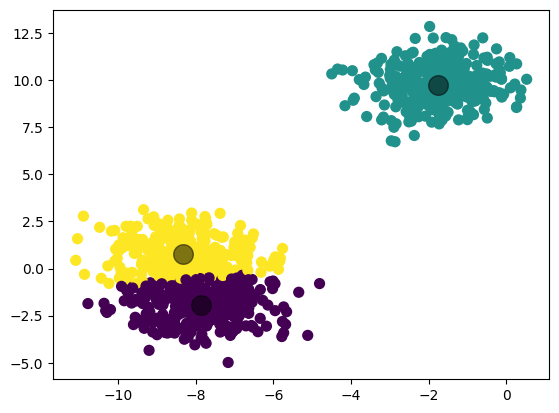

In [208]:
y_kmeans = kmeans_sklearn.predict(mat)
# Let's visualize the results by plotting the data colored by these labels. We will also plot the cluster centers as determined by the k-means estimator:

plt.scatter(mat[:, 0], mat[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans_sklearn.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

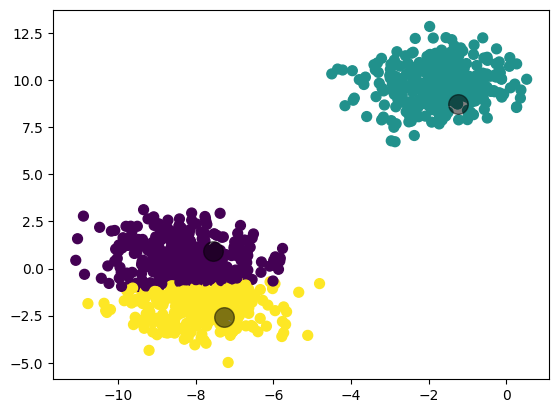

In [209]:
y_kmeans = kmeans_X.predict(mat)
# Let's visualize the results by plotting the data colored by these labels. We will also plot the cluster centers as determined by the k-means estimator:

plt.scatter(mat[:, 0], mat[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans_X.centroids
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [210]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

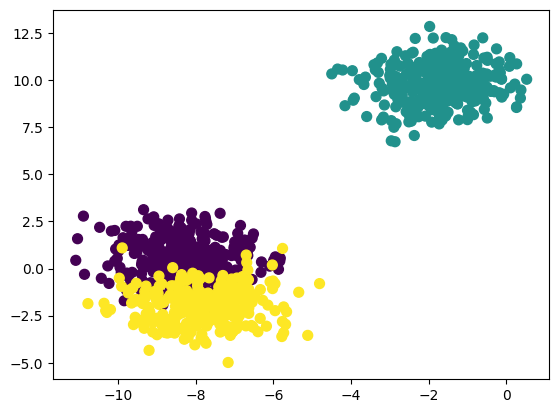

In [211]:
y_kmeans = labels
# Let's visualize the results by plotting the data colored by these labels. We will also plot the cluster centers as determined by the k-means estimator:

plt.scatter(mat[:, 0], mat[:, 1], c=y_kmeans, s=50, cmap='viridis')

#centers = kmeans_X.centroids
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [213]:
mat2, labels2 = make_clusters(n=1000, m=0, k=3)

In [225]:
kmeans_X._return_matrix_of_labels(mat)

array([0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0,

In [226]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [232]:
print(np.mean(labels == kmeans_X._return_matrix_of_labels(mat)))

0.937


In [233]:
print(np.mean(labels == kmeans_sklearn.labels_[::-1]))

0.861


In [242]:
centroids = kmeans_X.centroids
dist = cdist(mat, np.array(kmeans_X.centroids))

In [243]:
print(dist)

[[ 1.44145661 10.74938367  4.17820427]
 [ 1.47482226 11.35808872  2.17403434]
 [ 0.79057397 10.27759167  3.94697433]
 ...
 [ 4.58433981 14.420633    2.00780536]
 [ 2.46147512 11.8654589   1.07334766]
 [ 3.2661736  12.53120755  0.2769792 ]]


In [245]:
dist_squared = np.array([min([np.linalg.norm(m-c) for c in centroids]) for m in mat])

In [246]:
print(mat)

[[-8.97209642  1.24561902]
 [-7.8944079  -0.48732745]
 [-8.29599278  1.24161491]
 ...
 [-9.11029632 -3.36534598]
 [-7.27735589 -1.49562322]
 [-7.21033812 -2.29784381]]


In [253]:
gen_labels = kmeans_X.predict(mat)
gen_labels[999]

2

In [255]:
dist[0][1]

10.749383666731786

In [292]:
# Calculate minimum average distance in a cluster
centroids = kmeans_X.centroids
dist = cdist(mat, np.array(kmeans_X.centroids))
type(centroids)

# Use generated labels to choose what values to find distance for
for i in range(len(gen_labels)):
    print(dist[i][gen_labels[i]]) # Access minimum distances to their respective centroids
    # ex: gen_labels[0] = 0, gen_labels[1] = 0

1.4414566078521798
1.4748222602413266
0.7905739706546546
2.504742410234975
1.5006877667435894
2.2694739915528332
2.4955574823708395
1.479468993941293
1.48088163568099
1.8972504120732294
1.5417657221661332
1.8927922907862276
1.0503126799100038
1.5888879197172585
1.0283846508207115
3.5361697010955444
0.7102918438311748
1.1595181193629052
0.9677578127929405
0.3916487996580626
1.0025334981260225
1.5942504170987604
0.9837802317402775
1.7053638014849855
0.7860844363000281
0.9418254944601533
3.225139198177659
2.8235974012134273
1.4651831213299658
0.8468224672163692
0.8990892668212075
0.6746255188309406
2.411708235618114
1.0050576808581564
1.8226453200166983
0.6853326226853117
1.8401429469665562
1.3152687945729247
1.2078290834373218
0.3764821623372434
0.9903544907833881
1.8127466378824637
1.2808352403094614
1.3834861375400238
0.8971676998686275
1.4786628743262362
2.3426029887404547
2.810869574431245
0.5451818816042509
1.6787021034134382
1.645256289717515
0.7720157259451813
0.4241600695050742
1

In [293]:
type(centroids)

numpy.ndarray

In [ ]:

for i in range(len(gen_labels)):
    for 
    
a = (1/len(Ci))*(np.sum(intra_cluster_distances))
b = 

In [269]:
centroids = kmeans_X.centroids
labels_from_min_dist = np.array([np.argmin([np.linalg.norm(m-c)**2 for c in centroids]) for m in mat])

In [294]:
min_dist = np.array([min([np.linalg.norm(m-c)**2 for c in centroids]) for m in mat])

In [295]:
print(min_dist) # distances for each point to its centroid

[2.07779715e+00 2.17510070e+00 6.25007203e-01 6.27373454e+00
 2.25206377e+00 5.15051220e+00 6.22780715e+00 2.18882850e+00
 2.19301042e+00 3.59955913e+00 2.37704154e+00 3.58266266e+00
 1.10315673e+00 2.52456482e+00 1.05757499e+00 1.25044962e+01
 5.04514503e-01 1.34448227e+00 9.36555184e-01 1.53388782e-01
 1.00507341e+00 2.54163439e+00 9.67823544e-01 2.90826570e+00
 6.17928741e-01 8.87035262e-01 1.04015228e+01 7.97270228e+00
 2.14676158e+00 7.17108291e-01 8.08361510e-01 4.55119591e-01
 5.81633661e+00 1.01014094e+00 3.32203596e+00 4.69680804e-01
 3.38612607e+00 1.72993200e+00 1.45885109e+00 1.41738819e-01
 9.80802017e-01 3.28605037e+00 1.64053891e+00 1.91403389e+00
 8.04909882e-01 2.18644390e+00 5.48778876e+00 7.90098776e+00
 2.97223284e-01 2.81804075e+00 2.70686826e+00 5.96008281e-01
 1.79911765e-01 2.63881535e+00 1.88393980e+00 1.51815046e+00
 3.66743702e+00 1.00883048e+00 7.52832263e+00 1.76902959e+00
 6.55261043e+00 1.49005166e-01 7.58830335e+00 2.83193045e+00
 4.34690825e+00 1.701359

In [296]:
dist = np.array([max([np.linalg.norm(m-c)**2 for c in centroids]) for m in mat]) - np.array([min([np.linalg.norm(m-c)**2 for c in centroids]) for m in mat])

In [298]:
print(dist)

[113.47145206 126.83107868 105.00388324 130.55446945 117.42902755
 158.17567644 137.73031724 128.73481149 138.07571378 137.61590181
 125.43129489 134.78178533 114.22285185 124.97420983  88.83720732
 161.52332164 113.8228067  122.65742292 119.27401483  99.25441854
 120.09237061 130.8250595  119.51681394  82.0062151  112.02590608
 109.13775236 159.339024   147.01494546  91.63556998 117.22841812
 148.19736493 102.98153929 118.80794468 120.13415218  74.64100876
 111.78936548 136.95959003 120.78558466 124.47195112 106.71188267
 112.78838531 136.57433701 117.68127788 122.73884343  85.88685509
  83.53539328 147.06774503 117.11462387 110.55390805 131.91971551
  85.0787845  105.27545936 108.39387535 120.58398653  73.27292692
 105.79689541 132.38654817 100.22172633 115.50522117 126.57847663
 157.77941383 106.41915467 154.36421123  96.21961608 145.30088204
 125.28744313 152.81388402 110.02892839  77.09440998 138.54923294
  84.5577513  118.14442225 117.69133998 133.68870182 126.81107547
 125.28276

In [300]:
silhouette_matrix = (dist - min_dist)/(dist)

In [301]:
print(silhouette_matrix)

[0.98168881 0.98285041 0.99404777 0.95194546 0.98082192 0.96743803
 0.9547826  0.98299738 0.98411733 0.97384344 0.98104906 0.97341879
 0.99034207 0.97979931 0.98809536 0.92258396 0.99556754 0.98903872
 0.99214787 0.99845459 0.99163083 0.98057227 0.9919022  0.96453603
 0.99448405 0.99187233 0.93472081 0.94576944 0.97657284 0.99388281
 0.99454537 0.99558057 0.95104421 0.99159156 0.95549315 0.99579852
 0.97527646 0.98567766 0.98827968 0.99867176 0.99130405 0.97593947
 0.98605947 0.98440564 0.99062825 0.97382614 0.9626853  0.93253628
 0.99731151 0.97863821 0.96818398 0.99433858 0.9983402  0.97811637
 0.97428873 0.98565033 0.97229751 0.98993401 0.93482266 0.98602425
 0.9584698  0.99859983 0.95084156 0.97056805 0.9700834  0.98642035
 0.9166943  0.98918374 0.98085858 0.97352835 0.96232619 0.99233166
 0.99346978 0.97760912 0.98614993 0.97991006 0.97670653 0.90667247
 0.99296343 0.98380004 0.9556554  0.94791618 0.99223832 0.97994438
 0.98421312 0.96490009 0.98541435 0.99984968 0.98164019 0.9697

In [341]:
dist_0 = np.array(([([np.linalg.norm(m - c) ** 2 for c in centroids]) for m in mat]))

In [342]:
print(dist_0)

[[2.07779715e+00 1.15549249e+02 1.74573909e+01]
 [2.17510070e+00 1.29006179e+02 4.72642529e+00]
 [6.25007203e-01 1.05628890e+02 1.55786063e+01]
 ...
 [2.10161715e+01 2.07954656e+02 4.03128237e+00]
 [6.05885976e+00 1.40789115e+02 1.15207520e+00]
 [1.06678900e+01 1.57031163e+02 7.67174777e-02]]


In [322]:
dist_0[0][1]

100.28143269101037

In [343]:
for i in range(len(dist_0)):
    dist_0[i] = sorted(dist_0[i])

In [344]:
dist_0

array([[2.07779715e+00, 1.74573909e+01, 1.15549249e+02],
       [2.17510070e+00, 4.72642529e+00, 1.29006179e+02],
       [6.25007203e-01, 1.55786063e+01, 1.05628890e+02],
       ...,
       [4.03128237e+00, 2.10161715e+01, 2.07954656e+02],
       [1.15207520e+00, 6.05885976e+00, 1.40789115e+02],
       [7.67174777e-02, 1.06678900e+01, 1.57031163e+02]])

In [345]:
mid_dist = []
for i in range(len(dist_0)):
    mid_dist.append(dist_0[i][1])

In [346]:
mid_dist

[17.457390940533365,
 4.726425293324386,
 15.578606336996623,
 20.80424315842144,
 16.38185043357493,
 7.676965694921353,
 17.24859944641549,
 5.397427339067938,
 4.535522780197275,
 4.841718841463664,
 12.818899493034692,
 11.107731808672318,
 6.176451015328042,
 3.8082685981324147,
 20.614458171739503,
 18.076118182285718,
 8.46099323506268,
 6.600850290771482,
 9.514947191828625,
 10.9813289843722,
 7.632978763111378,
 9.509565602334927,
 7.498192180745033,
 27.06644450688072,
 7.536031458688814,
 7.033542573233679,
 14.231981918987348,
 16.324783614077585,
 23.657235455836446,
 8.707797502865146,
 7.130604672086664,
 15.465590883391604,
 24.45933565127732,
 7.613518725819098,
 28.65259367791701,
 11.834104409023663,
 7.401136142033216,
 4.942180043351474,
 7.780417208283932,
 11.932563947855279,
 6.5062905513201645,
 6.282405179118862,
 14.281686161552285,
 4.704446268276893,
 19.55718815761043,
 24.874345127438605,
 6.909661678060841,
 29.199532898762886,
 9.245853662127844,
 4.45

In [347]:
silhouette_matrix2 = (mid_dist - min_dist)/(mid_dist)

In [348]:
print(silhouette_matrix2)

[0.88097894 0.53980005 0.95988042 0.69843966 0.8625269  0.32909532
 0.63893839 0.59446819 0.51648122 0.25655346 0.81456742 0.67746227
 0.82139311 0.33708331 0.94869742 0.30823111 0.94037172 0.79631681
 0.90157011 0.98603186 0.86832488 0.73272865 0.87092575 0.89255088
 0.91800343 0.87388499 0.26914446 0.51161973 0.9092556  0.91764757
 0.88663493 0.97057212 0.76220382 0.86732272 0.88405811 0.96031125
 0.54248564 0.64996581 0.81249706 0.98812168 0.84925327 0.4769439
 0.88512989 0.59314364 0.95884327 0.91210044 0.2057804  0.7294139
 0.96785334 0.36792715 0.7725677  0.96120597 0.98393225 0.83656824
 0.90565495 0.77368931 0.71981604 0.94517311 0.74050902 0.79389082
 0.16813009 0.98495711 0.15300365 0.88440456 0.13862628 0.82372398
 0.46194639 0.92538429 0.91819781 0.36374326 0.73032851 0.91332737
 0.91789844 0.67490093 0.77120551 0.81231086 0.89983235 0.60188793
 0.8502931  0.77902127 0.43663141 0.80636162 0.96433026 0.3483893
 0.87951142 0.78272605 0.79626468 0.99876749 0.90416372 0.7992173